# [Chefkoch.de](http://www.chefkoch.de/)
------

## Ziel: 
### Scraping der Hauptrezeptesammlung von über 300'000 verschiedenen Rezepten (2.Teil)

In [1]:
import datetime as dt
import csv
from bs4 import BeautifulSoup
from lxml import html
from datetime import datetime
from multiprocessing import Pool
from random import uniform, choice
from time import sleep, time
import requests
import os.path
import re
import os

In [61]:
DATAST_FOLDER = 'input/test/'
IMGS_FOLDER  = 'input/images/search_thumbnails/'
DFILE_NAME    = 'recipe_details_' + dt.datetime.now().strftime('%d-%m-%Y') + '.csv'
PIC_LIST      = 'pic_list_' + dt.datetime.now().strftime('%d-%m-%Y') + '.csv'

#### Diesmal ist das Ziel die Zutatenliste, die Zubereitung, die Tags und alle Bilder jedes einzelnen Rezeptes zu laden.
这次的目标是加载成分列表、准备、标签和每个单独食谱的所有图片
### Beispiel:

In [32]:
from IPython.display import Image
PATH = "/Users/shu/Desktop/xyu_gatech/Food-Recipe-CNN/"
Image(filename = PATH + "dPO2Ot8.png", width='100%', height=140)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/shu/Desktop/xyu_gatech/Food-Recipe-CNN/dPO2Ot8.png'

Dieses Rezept hat die Tags **Backen** und **Brot oder Brötchen**.
Ausserdem hat es 31 weitere Bilder die wir noch brauchen.

In [33]:
def get_list_of_recipes():
    recipe_links = []
    chef_file = DATAST_FOLDER + 'chefkoch_rezepte_27-12-2017.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            try:
                recipe_links.append(row[-2])
            except: 
                continue 
    return(recipe_links)

def get_list_of_scraped_recipes():
    recipe_links = []
    recipes_file = DATAST_FOLDER + DFILE_NAME
    if os.path.isfile(recipes_file):
        with open(recipes_file, 'r') as f:
            chefkoch = csv.reader(f)
            for row in chefkoch:
                try:
                    recipe_links.append(row[0])
                except: 
                    continue
    return(recipe_links)

def list_to_scrape():
    print('AUFGERUFEN')
    l_scraped = get_list_of_scraped_recipes()
    l_all     = get_list_of_recipes()
    
    l_to_scrape = list(set(l_all) - set(l_scraped))
    print('Difference of sets:', len(l_to_scrape))
    
    return(l_to_scrape)

In [35]:
recipe_links = list_to_scrape()

AUFGERUFEN
Difference of sets: 316756


In [79]:
def write_recipe_details(data):
    dpath = DATAST_FOLDER + DFILE_NAME
    with open(dpath, 'a') as f:
        writer = csv.writer(f)
        try:
            writer.writerow((data['link'],
                             data['ingredients'],
                             data['zubereitung'],
                             data['tags'],
                             data['gedruckt:'],
                             data['n_pics']
                             #data['reviews'],
                             #data['gespeichert:'],
                             #data['Freischaltung:'],
                             #data['author_registration_date'],
                             #data['author_reviews']
                            ))
        except:
            writer.writerow('')

### Die Links zu den Bildern werden in einer Liste gespeichert und seperat runtergeladen.

In [80]:
def write_picture_list(pics):
    dpath = DATAST_FOLDER + PIC_LIST
    with open(dpath, 'a') as f:  #, newline=''
        writer = csv.writer(f)
        try:
            writer.writerow(pics)
        except:
            writer.writerow('')

In [38]:
# def get_stats(soup):
#     stats = {}
#     # DROPPED
#     # anzahl bewertungen
#     reviews = soup.find('div', id="recipe__rating").find('span', class_ = "rating__total-votes m-r-s").text
#     #stats['reviews'] = reviews
    
#     # andere statistiken
#     if reviews != '(0)':
#         stats_table = soup.find('div', id="recipe-statistic").find_all('table')[1].find_all('tr')[1:5]
#     else:
#         stats_table = soup.find('div', id="recipe-statistic").find_all('table')[0].find_all('tr')[1:5]
        
#     for tr in stats_table:
#         stat_name  = tr.find_all('td')[0].text.strip()
#         stat_value = tr.find_all('td')a[1].text.strip().split(' ')[0]
#         stats[stat_name] = stat_value
#     return(stats)

# def get_n_pictures(html_text):
#     tree = html.fromstring(html_text)
#     # alle bilder links
#     links_pics = tree.xpath('//div')
#     links_pics = tree.xpath('//div[contains(@id, "slider")]//img[@class="slideshow-image lazyload"]/@src')
#     return links_pics

# def get_zubereitung(soup):
#     zuber = soup.find('div', id="rezept-zubereitung").text.strip()
#     zuber = zuber.replace('\n', ' ').replace('\r', '')
#     return zuber

# def get_ingredients(soup):
#     # liste von zubereitungen
#     ingredient_list = []
#     amounts_ingredients = soup.find('table', class_="incredients").find_all('tr')
    
#     for tr in amounts_ingredients:
#         am = tr.find_all('td')[0].text.strip() # amount
#         td = tr.find_all('td')[1].text.strip().split(',')[0] # ingredient
#         td = re.sub('\(.*?\)','', td)
#         ingr = am + '@' + td
#         ingredient_list.append(ingr)
        
#     return(str.join(',', ingredient_list))

# def get_tags(soup):
#     tags = []
#     tag_cloud = soup.find('ul', class_ = 'tagcloud').find_all('li')
#     for li in tag_cloud:
#         tags.append(li.find('a').text.strip())
        
#     return(str.join(',', tags))

# # DROPPED
# #def get_author_info(soup):
# #    author = {}
# #    author['author_registration_date'] = soup.find('div', class_="user-details").find('p').find('br').previous_sibling.strip()
# #    author['author_reviews'] = soup.find('div', class_="user-details").find('p').find('br').next_sibling.strip()
# #    return(author)

In [88]:
def get_stats(soup):
    stats = {}
    # DROPPED
    # anzahl bewertungen
    reviews = soup.find("div",class_="ds-box") [-14].text.strip()
    #stats['reviews'] = reviews
    
    # andere statistiken
    if reviews != '(0)':
        stats_table = soup.find('div', id="recipe-statistic").find_all('table')[1].find_all('tr')[1:5]
    else:
        stats_table = soup.find('div', id="recipe-statistic").find_all('table')[0].find_all('tr')[1:5]
        
    for tr in stats_table:
        stat_name  = tr.find_all('td')[0].text.strip()
        stat_value = tr.find_all('td')[1].text.strip().split(' ')[0]
        stats[stat_name] = stat_value
    return(stats)

def get_n_pictures(html_text):
    tree = html.fromstring(html_text)
    # alle bilder links
    links_pics = tree.xpath('//div[contains(@class,"ds-mb-left recipe-image")] \ //img [@class="i-amphtmI-fill-content i-amphtmi-replaced-content"j/@src')
    return links_pics

def get_zubereitung(soup):
    zuber = soup.find_all("div",class_="ds-box") [-14].text.strip()
    zuber = zuber.replace('\n', ' ').replace('\r', '')
    return zuber

def get_ingredients(soup):
    # liste von zubereitungen
    ingredient_list = []
    amounts_ingredients = soup.find('table', class_="ingredients table-header").find_all('tr')

    for tr in amounts_ingredients:
        am = tr.find_all('td')[0].text.strip().replace(" ","")  # amount
        td = tr.find_all('td')[1].text.strip().split(',')[0] # ingredient
        td = re.sub('\(.*?\)','', td)
        ingr = am + '@' + td
        ingredient_list.append(ingr)
        
    return(str.join(',', ingredient_list))

def get_tags(soup):
    tags = []
    tag_cloud = soup.find('ul', class_ = "r-nav-box r-std").find_all('li')
    for li in tag_cloud:
        tags.append(li.find('a').text.strip())
        
    return(str.join(',', tags))

# DROPPED
#def get_author_info(soup):
#    author = {}
#    author['author_registration_date'] = soup.find('div', class_="user-details").find('p').find('br').previous_sibling.strip()
#    author['author_reviews'] = soup.find('div', class_="user-details").find('p').find('br').next_sibling.strip()
#    return(author)

In [89]:
desktop_agents = ['Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/602.2.14 (KHTML, like Gecko) Version/10.0.1 Safari/602.2.14',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.98 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 6.1; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36',
                 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) Gecko/20100101 Firefox/50.0']

def random_headers():
    return {'User-Agent': choice(desktop_agents),'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'}

In [90]:
failed_urls = []

In [91]:
def get_html(url):
    i = 5
    while i > 0:
        try:
            page = requests.get(url, headers=random_headers())
            if page.status_code != requests.codes.ok:
                page.raise_for_status()
            else:
                print(url)
                return page.text        
        except requests.exceptions.RequestException as e:
            print("Could not fetch " + url)
            print(e)
            # sichere url zu einer Liste von fehlgeschlagenen Links
            failed_urls.append(url)
            sleep(5)
            i = i - 1
            continue

    print("Link zum 5. Mal nicht abrufbar " + url + " ,abbrechen")
    return None

In [103]:
def get_recipe_info(url):
    sleep_time = uniform(2, 4)
    sleep(sleep_time)
    
    html_text = get_html(url)
    try:
        soup = BeautifulSoup(html_text, 'lxml')
        
        # tags ingredients preparation
        ingredient_list = get_ingredients(soup)
        tags = get_tags(soup)
        prep = get_zubereitung(soup)

        
        # pics
        list_pics = get_n_pictures(html_text)
        n_pics = len(list_pics)
        
        # update dictionary
        stats = get_stats(soup)
        #author_info = get_author_info(soup)
        
        # write dictionary
        data = {'link' : url,
                'ingredients' : ingredient_list,
                'zubereitung' : prep,
                'tags': tags, 
                'n_pics': n_pics}
        data.update(stats)
        #data.update(author_info)
        
    except:
        data = ''
        list_pics = ['error']
    
    # write file 
    print("ingredients: ", ingredient_list)
    print('zubereitung', prep)
    print(data['link'],data['ingredients'],
                             data['zubereitung'],
                             data['tags'],
                             data['gedruckt:'],
                             data['n_pics'])
    write_recipe_details(data)
    write_picture_list(list_pics)



In [104]:
recipe_links[0]

'https://www.chefkoch.de/rezepte/2812711433261492/Bunte-Brownie-Cake-Pops.html'

In [105]:
len(recipe_links)
for i in range(100):
    get_recipe_info(recipe_links[i])

https://www.chefkoch.de/rezepte/2812711433261492/Bunte-Brownie-Cake-Pops.html
ingredients:  400g@Kuchen ,200g@Schokolinse,200g@Doppelrahmfrischkäse,2EL@Kakaopulver,150g@Zartbitterkuvertüre,150g@Kuvertüre,1Würfel@Kokosfett,@Zuckerperlen und -streusel und 36 Lollistiele
zubereitung                   Portionen                  umrechnen


TypeError: string indices must be integers

In [77]:
start_time = datetime.now()
print(start_time)
with Pool(15) as p:
    p.map(get_recipe_info, recipe_links[0:50])
print("--- %s seconds ---" % (datetime.now() - start_time))
failed_urls

2022-12-03 20:46:55.651993


Process SpawnPoolWorker-416:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-417:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-435:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-434:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-446:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-447:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-459:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-460:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

KeyboardInterrupt: 

In [73]:
recipe_links[1:50]

['https://www.chefkoch.de/rezepte/1399001244820478/Rettich-Sauerkraut-Salat.html',
 'https://www.chefkoch.de/rezepte/310271112171920/Mohr-im-Hemd.html',
 'https://www.chefkoch.de/rezepte/715461174313281/Apfel-Nuss-Kuchen.html',
 'https://www.chefkoch.de/rezepte/3138101467286797/Vollkornbroetchen.html',
 'https://www.chefkoch.de/rezepte/505811145585356/Nektarinen-Muffins.html',
 'https://www.chefkoch.de/rezepte/965311202222951/Marinierter-Hering-la-Rothaar.html',
 'https://www.chefkoch.de/rezepte/3173761472387194/Ananas-Couscous.html',
 'https://www.chefkoch.de/rezepte/168481073149271/Pina-Colada-Muffins.html',
 'https://www.chefkoch.de/rezepte/1080651213777263/Gnocchi-auf-Mais-Karotten-Sosse-mit-Wuerstchenspiess.html',
 'https://www.chefkoch.de/rezepte/518831148120243/Hering-Kartoffel-Auflauf.html',
 'https://www.chefkoch.de/rezepte/1475901252739766/Kaesesahnetorte.html',
 'https://www.chefkoch.de/rezepte/3219571479053944/Chicoreesalat-mit-Obst-und-Sojajoghurt.html',
 'https://www.chef

In [74]:
p = Pool(15)
with p:
    p.map(get_recipe_info, recipe_links[0:50])

Process SpawnPoolWorker-221:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-222:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-233:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-237:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-248:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-249:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

Process SpawnPoolWorker-261:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'get_recipe_info' on <module '__main__' (built-in)>
Process SpawnPoolWorker-262:
Traceback (most recent call last):
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/shu/.pyenv/versions/3.8.13/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args

KeyboardInterrupt: 

#### 15'360 Rezepte wurden pro Stunde in *recipe_details_27-12-2017.csv* heruntergeladen. Gesamte Laufzeit: 20h 36min
#### Die cvs Datei enthält nun die sehr wichtigen Daten

In [51]:
DFILE_NAME    = 'recipe_details_' + '27-12-2017' + '.csv'
PIC_LIST      = 'pic_list_' + '27-12-2017' + '.csv'
print(DATAST_FOLDER+DFILE_NAME)
import pandas as pd
recipe_details = pd.read_csv(DATAST_FOLDER+DFILE_NAME, header=None)
recipe_details.head() # erste 5 zeilen

input/test/recipe_details_27-12-2017.csv


EmptyDataError: No columns to parse from file

# Herunterladen der Bilder

Bis jetzt sind nur die Thumbnails heruntergeladen. Die Grösse beträgt 164x140. Zu finden sind die Thumbnails unter input/images/search_thumbnails. Beispiel:

In [13]:
from IPython.display import Image
PATH = "input/images/search_thumbnails/"
Image(filename = PATH + "recipe-1742451283182013-0.jpg", width=164, height=140)

FileNotFoundError: [Errno 2] No such file or directory: 'input/images/search_thumbnails/recipe-1742451283182013-0.jpg'

Chefkoch erlaubt seinen Nutzern Bilder vom Rezept hochzuladen. Oftmals ist es so, dass es mehr als ein Bild pro Rezept gibt. Um möglichst viele Daten zu haben, ladet man natürlich alle Bilder herunter. Die Links sind in der Datei *pic_list_27-12-2017.csv*

In [14]:
import pandas as pd
pic_list = pd.read_csv('input/test/fixed.csv', header=None)
pic_list.head()

FileNotFoundError: [Errno 2] No such file or directory: 'input/test/fixed.csv'

Zuerst überprüfen wir ob die Liste leere Einträge hat, welche entfernt werden müssen.

In [15]:
pic_list[pic_list[1].isnull()] # 2 NaN entries

NameError: name 'pic_list' is not defined

In [8]:
pic_list = pic_list.drop(pic_list.index[105484])
pic_list = pic_list.drop(pic_list.index[140099])

In [9]:
pic_list[pic_list[1].isnull()] # No more NaN entries

Empty DataFrame
Columns: [0, 1]
Index: []

**689'651** Bilder von **107'052** Rezepten müssen noch heruntergeladen werden.

### Bisherige Statistik: (Stand: Ende Dezember 2017)
    Chefkoch.de enthält:
        - Insgesamt 879'620 Bilder
        - 316'756 Rezepte
            - Davon enthalten 189'969 ein oder mehr Bilder
                - Davon enthalten 107'052 Rezepte mehr als 2 Bilder
            - 126'787 enthalten kein Bild

In [19]:
links = []
for index, row in pic_list.iterrows():
    link = row[1].split(',')
    if len(link) > 1: links.append(link[1:]) # ignorieren falls weniger als ein Link vorhanden

        
print(len(links))
count=0
for ll in links:
    for l in ll:
        count+=1
print(count)

NameError: name 'pic_list' is not defined

In [194]:
links[0]

['https://static.chefkoch-cdn.de/ck.de/rezepte/174/174245/280352-420x280-fix-johannisbeer-cupcakes-mit-karamellperlen.jpg',
 'https://static.chefkoch-cdn.de/ck.de/rezepte/174/174245/280354-420x280-fix-johannisbeer-cupcakes-mit-karamellperlen.jpg']

In [179]:
partial_ids = []
for link in links:
    partial_ids.append(link[0].split('/')[6]) # extrakt partial id
partial_ids[:11]

['174245',
 '8811',
 '32579',
 '187900',
 '58201',
 '80531',
 '81710',
 '128961',
 '95816',
 '231697',
 '7308']

In [18]:
title_ids = []
for link in links:
    title_ids.append(link[0].split('fix-')[1].split('.')[0])
title_ids[:5]

NameError: name 'links' is not defined

In [148]:
def get_list_of_recipes_id():
    recipe_links = []
    chef_file = DATAST_FOLDER + 'chefkoch_rezepte_27-12-2017.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            try:
                recipe_links.append(row[-2])
            except:
                print('ERROR')
                continue 
    return(recipe_links)

all_ids = get_list_of_recipes_id()
all_ids_clean = []
for id in all_ids[1:]: # erste spalte überspringen, es ist der spalten name
    all_ids_clean.append(id[32:].lower()) # 'recipe-' extrahieren
del all_ids[:]
all_ids_clean[:10]

['3449791514066439/bratapfel-rotkohl.html',
 '3449721514056932/fruehstueckswolke-7-aus-fiefhusen.html',
 '3449701514054063/deichgrafensalat-von-der-westkueste.html',
 '3449651514047893/geschichteter-kohl.html',
 '3449681514052511/rinderlendenragout.html',
 '3449481514034645/blaukraut-mit-butter-maroni.html',
 '3449641514047091/sauerbraten-la-tick.html',
 '3449571514042406/punschtorte.html',
 '3449471514033424/gebackene-oberlaender.html',
 '3449241513953107/mcmoes-bunter-pasta-topf-allerlei.html']

In [191]:
print(len(all_ids_clean))
print(len(partial_ids))
print(len(title_ids))

316767
107052
107052


In [17]:
%%time
import json
matches = {} # key: recipe_id , value: pics_list
lost = [] # sichere jede reciped_id wo es keinen match finden konnte => kein match
for i in range(len(title_ids)-1):
    match = [s for s in all_ids_clean if title_ids[i] in s and s.startswith(partial_ids[i])]
    if len(match) == 0: # kein match
        lost.append(i)
        continue
    r_id = match[0].split('/')[0]
    matches[r_id] = links[i]

with open('input/test/matches.txt', 'w') as file:
    file.write(json.dumps(matches))
#print(matches)
print('Lost:', len(lost))
print(lost)

NameError: name 'title_ids' is not defined

## Download von 630'770 Bildern

In [3]:
from datetime import datetime
from time import sleep
import urllib.request
from multiprocessing import Pool
from random import uniform
import os

In [9]:
# beispiel: recipe-2841831436245733-1.jpg
IMG_PATH = 'input/images/search_images/'


In [10]:
def get_img_from_dict(i_dict):
    for idx, linn in enumerate(i_dict[1]):
        try:
            img_name = IMG_PATH + 'recipe-' + str(i_dict[0]) + '-' + str(idx+1) + '.jpg'
            urllib.request.urlretrieve(linn, img_name)
        except:
            print('Error:', i_dict[0])
    sleep_time = uniform(2., 3.) # schone den server mit anfragen
    sleep(sleep_time)

In [16]:
IMG_PATH = 'input/images/'
url="https://static.chefkoch-cdn.de/ck.de/rezepte/111/111619/119485-420x280-fix-melonen-zwieback-brei.jpg"
img_name=IMG_PATH +'test.jpg'
urllib.request.urlretrieve(url, img_name)

FileNotFoundError: [Errno 2] No such file or directory: 'input/images/test.jpg'

In [12]:
start_time = datetime.now()
print(start_time)

with Pool(20) as p:
    p.map(get_img_from_dict, matches.items())

print("--- %s seconds ---" % (datetime.now() - start_time))

2022-12-03 18:46:00.468096


NameError: name 'matches' is not defined

Nach fast 5 Stunden sind alle Bilder unter /input/images/search_images/ zu finden. **32.36 GB**
### Beispiel:

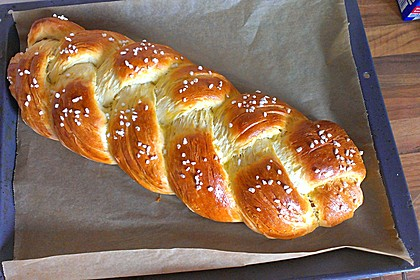

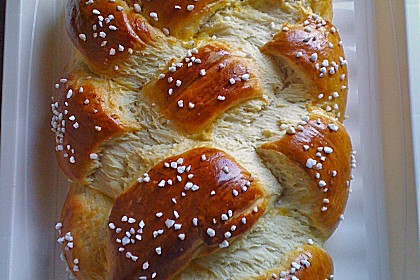

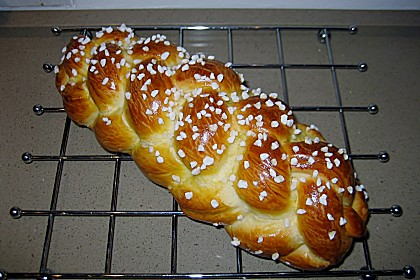

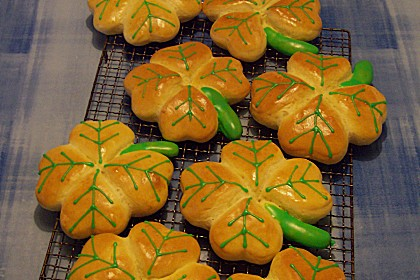

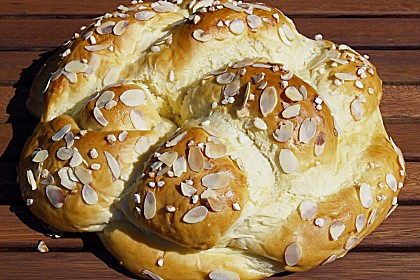

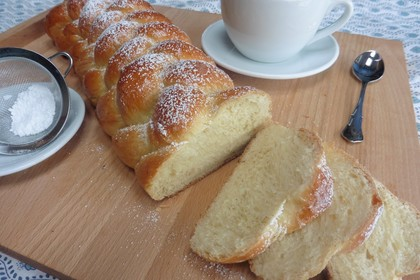

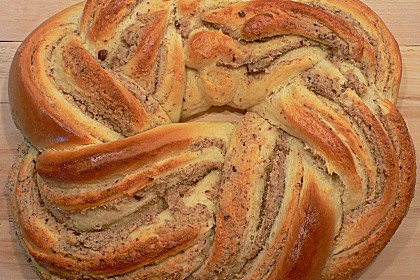

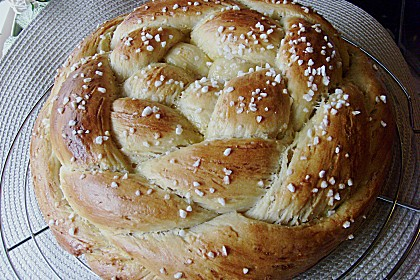

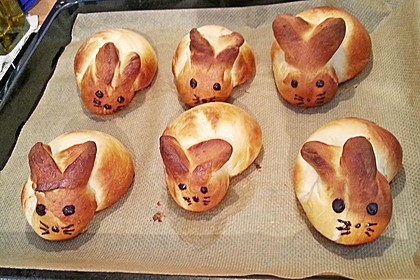

In [19]:
import os
from IPython.display import Image, display
PATH = "input/images/search_images/"
images = []
for i in range(1, 10):
    images.append(Image(filename = PATH + "recipe-378801124204434-"+str(i)+".jpg", width=420, height=280))
display(*images)